Epoch 1, Loss: 22.65
Epoch 2, Loss: 23.89
Epoch 3, Loss: 23.78
Epoch 4, Loss: 23.44
Epoch 5, Loss: 23.95
Epoch 6, Loss: 23.53
Epoch 7, Loss: 22.75
Epoch 8, Loss: 22.52
Epoch 9, Loss: 22.57
Epoch 10, Loss: 23.14
Epoch 11, Loss: 21.42
Epoch 12, Loss: 21.60
Epoch 13, Loss: 22.73
Epoch 14, Loss: 21.99
Epoch 15, Loss: 23.56
Epoch 16, Loss: 22.45
Epoch 17, Loss: 22.02
Epoch 18, Loss: 22.37
Epoch 19, Loss: 23.02
Epoch 20, Loss: 22.28


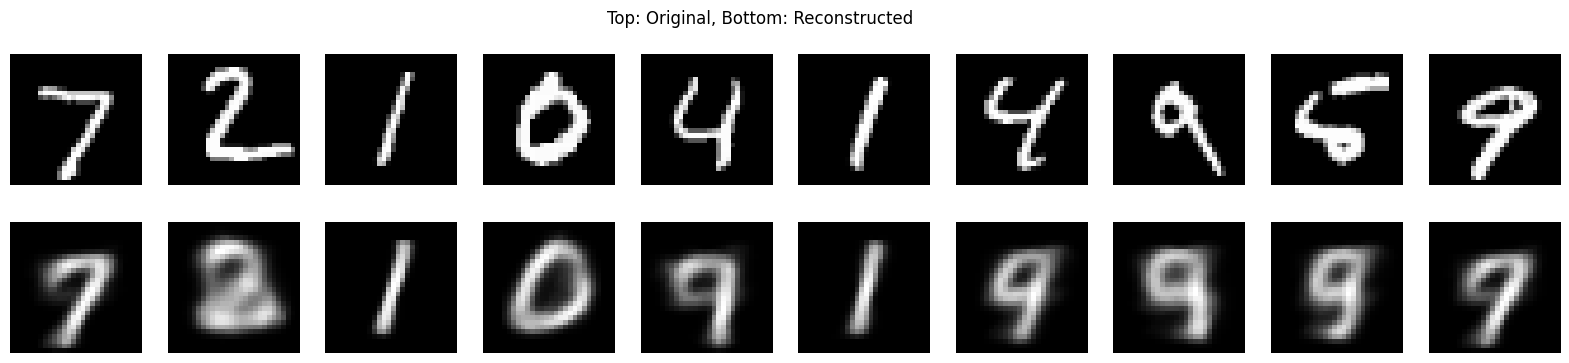

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess MNIST data
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
x_train = np.reshape(x_train, (-1, 28, 28, 1))
x_test = np.reshape(x_test, (-1, 28, 28, 1))

latent_dim = 2  # for easy visualization

# ----- Encoder -----
class Encoder(Model):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.flatten = layers.Flatten()
        self.dense1 = layers.Dense(512, activation="relu")
        self.mu = layers.Dense(latent_dim)
        self.log_var = layers.Dense(latent_dim)

    def call(self, x):
        x = self.flatten(x)
        x = self.dense1(x)
        mu = self.mu(x)
        log_var = self.log_var(x)
        return mu, log_var

# ----- Reparameterization Trick -----
def sample_z(mu, log_var):
    epsilon = tf.random.normal(shape=tf.shape(mu))
    return mu + tf.exp(0.5 * log_var) * epsilon

# ----- Decoder -----
class Decoder(Model):
    def __init__(self):
        super(Decoder, self).__init__()
        self.dense1 = layers.Dense(512, activation="relu")
        self.dense2 = layers.Dense(28 * 28, activation="sigmoid")
        self.reshape_layer = layers.Reshape((28, 28, 1))

    def call(self, z):
        x = self.dense1(z)
        x = self.dense2(x)
        return self.reshape_layer(x)

# ----- VAE Model -----
class VAE(Model):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def call(self, x):
        mu, log_var = self.encoder(x)
        z = sample_z(mu, log_var)
        reconstructed = self.decoder(z)
        return reconstructed, mu, log_var

# ----- Loss Function -----
def compute_loss(x, reconstructed, mu, log_var):
    bce = tf.keras.losses.binary_crossentropy(
        tf.reshape(x, [-1, 28 * 28]),
        tf.reshape(reconstructed, [-1, 28 * 28])
    )
    reconstruction_loss = tf.reduce_sum(bce, axis=-1)
    kl_loss = -0.5 * tf.reduce_sum(
        1 + log_var - tf.square(mu) - tf.exp(log_var), axis=-1
    )
    return tf.reduce_mean(reconstruction_loss + kl_loss)

# Instantiate models and optimizer
encoder = Encoder(latent_dim)
decoder = Decoder()
vae = VAE(encoder, decoder)
optimizer = tf.keras.optimizers.Adam()

# ----- Training Step -----
@tf.function
def train_step(x):
    with tf.GradientTape() as tape:
        reconstructed, mu, log_var = vae(x)
        loss = compute_loss(x, reconstructed, mu, log_var)
    grads = tape.gradient(loss, vae.trainable_variables)
    optimizer.apply_gradients(zip(grads, vae.trainable_variables))
    return loss

# ----- Training -----
epochs = 20
batch_size = 128
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(1024).batch(batch_size)

for epoch in range(epochs):
    for step, batch in enumerate(train_dataset):
        loss = train_step(batch)
    print(f"Epoch {epoch + 1}, Loss: {loss.numpy():.2f}")

# ----- Visualization -----
def plot_reconstruction(model, data=x_test):
    reconstructed, _, _ = model(data[:10])
    fig, axs = plt.subplots(2, 10, figsize=(20, 4))
    for i in range(10):
        axs[0, i].imshow(data[i].squeeze(), cmap='gray')
        axs[0, i].axis('off')
        axs[1, i].imshow(reconstructed[i].numpy().squeeze(), cmap='gray')
        axs[1, i].axis('off')
    plt.suptitle("Top: Original, Bottom: Reconstructed")
    plt.show()

plot_reconstruction(vae)
